# Machine Learning Demonstrations

In this notebook, we showcase examples of how effectively use the kdb+/q clustering library, contained within the kdb+/q machine learning toolkit (ML-toolkit).

<div class="alert alert-danger">
To run the below notebook, ensure that dependencies specified in <b>requirements.txt</b> have been correctly installed.
</div>

## Clustering

Clustering is a technique used in both data mining and machine learning to group similar data points together in order to identify patterns in their distributions. The task of clustering data can be carried out using a number of algorithms. Here we outline implementations of Affinity Propagation, CURE (Clustering Using REpresentatives), DBSCAN (Density-based spatial clustering of applications with noise), hierarchical and k-means clustering.

The algorithms defined here work based on distinct clustering methodologies namely; connectivity-based, centroid-based or density-based models.

-   Connectivity models, which include hierarchical and CURE, cluster data based on distances between individual data points.
-   Centroid models such as k-means define clusters based on distances from single points which represent the cluster.
-   Density-based models such as DBSCAN define clusters based on clusters being within a certain distance of each other and in defined concentrations.

Each algorithm works by iteratively joining, separating or reassigning points until the desired number of clusters have been achieved. The process of finding the correct cluster for each data point is a case of trial and error, where parameters must be altered in order to find the optimum solution.

## Machine Learning Toolkit

The ML-Toolkit contains general use utilities, an implementation of the FRESH (Feature Extraction based on Scalable Hypothesis tests) algorithm and cross validation functions. The primary purpose of these libraries are to provide kdb+/q users with access to commonly-used ML functions for preprocessing data, extracting features and scoring results.

The clustering section of the toolkit is used throughout this notebook and can be loaded using the below syntax.

In [1]:
\l ml/ml.q
.ml.loadfile`:clust/init.q

## PyClustering

Throughout the notebook, we use datasets from the python `pyclustering` samples library. All of the necessary functions provided in each can be imported using embedPy as shown below.

In [2]:
     .p.import[`mpl_toolkits.mplot3d]`:Axes3D;
fcps:.p.import[`pyclustering.samples.definitions]`:FCPS_SAMPLES
smpl:.p.import[`pyclustering.samples.definitions]`:SIMPLE_SAMPLES
read:.p.import[`pyclustering.utils]`:read_sample
skds:.p.import`sklearn.datasets
hc:  .p.import[`scipy.cluster]`:hierarchy

## Sections

This notebook is split into 3 distinct sections which cover different use cases for the FRESH algorithm.
1. [Clustering Algorithms](#Algos):
    - [Affinity Propagation](#AP)
    - [CURE](#CURE)
    - [DBSCAN](#DBSCAN)
    - [Hierarchical](#HC)
    - [K-Means](#KMeans)
2. [Comparing Algorithms](#Comp)

In [3]:
\c 20 100
\l ../utils/graphics.q

---

<a id='Algos'></a>
# Clustering Algorithms

In this section we show examples for each of the clustering algorithms implemented within the toolkit.

---

<a id='AP'></a>
## Affinity Propagation

Affinity propagation is a clustering algorithm built on the basis of "message passing" between data points. Similarly to clustering algorithms such DBSCAN, affinity propagation does not require the number of clusters to be stated by the user as a parameter. The algorithm finds "exemplars" which are datapoints representative of each clusters.

### Inputs

Affinity propagation is called using the function `.ml.clust.ap` which takes the followning arguments:
* `d` is data points in matrix form
* `dmp` is the damping coefficient, a number between 0 and 1
* `p` is the preference for the diagonal of the similarity matrix, either a symbol e.g. ```min`max`avg`med`` or a value `0.`, `1.`, etc.
* `b` is a boolean flag indicating whether to plot clusters each iteration (`1b`), on the final iteration (`0b`) or not at all (`()`).

### Examples

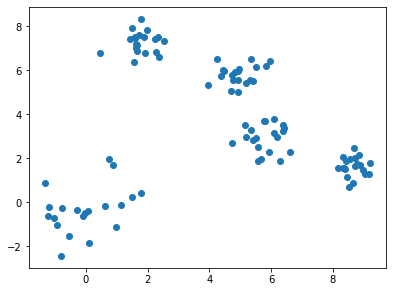

In [21]:
d7:flip("FF";",")0:`:../data/ritchievink.csv
plt[`:scatter]. flip d7;
plt[`:show][];

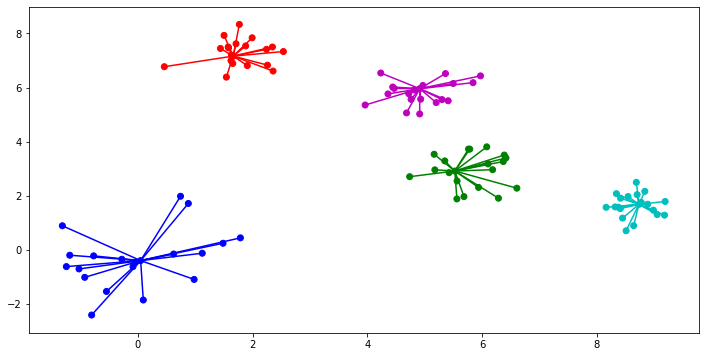

In [22]:
.ml.clust.ap[d7;.5;`med;0b];

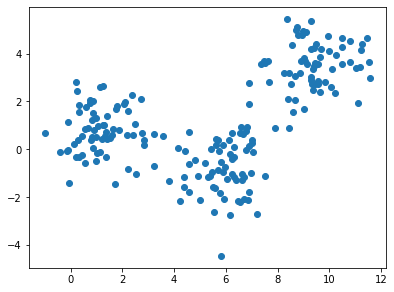

In [23]:
d8:skds[`:make_blobs][`n_samples pykw 200;`random_state pykw 449]`
plt[`:scatter]. flip d8@:0;
plt[`:show][];

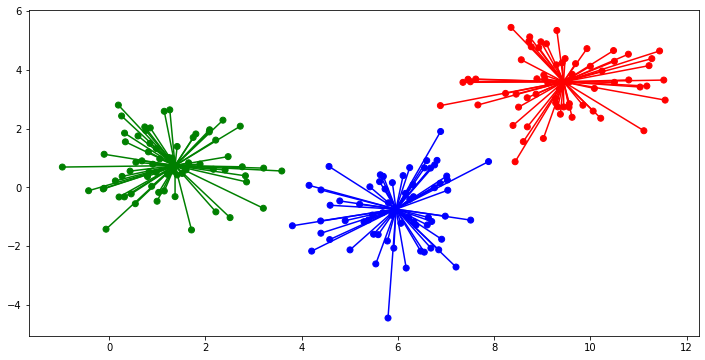

In [24]:
.ml.clust.ap[d8;.9;`min;0b];

---

<a id='CURE'></a>
## CURE (Clustering Using REpresentatives)

CURE clustering is a technique used to deal with datasets containing outliers and clusters of varying sizes and shapes. Each cluster is represented by a specified number of representative points. These points are chosen by taking the the most scattered points in each cluster and shrinking them towards the cluster centre by a fixed amount, known as the compression.

In the implementation below, a k-d tree is used in order to store the representative points of each cluster (more information [here](https://code.kx.com/v2/ml/toolkit/clustering/kdtree)). Both q and C implementations of the tree are available and are specified as an argument.

### Inputs

CURE is called using the function `.ml.clust.cure` which takes the followning arguments:
* `d` is data points in matrix form
* `k` is the number of clusters
* `r` is the number of representative points
* `i` is a dictionary of inputs in the form:
    - `df` is the distance function as a symbol: `` `e2dist`edist`mdist``
    - `c` is the compression
    - `b` is a boolean, `1b` for C, `0b` for q
    - `s` is a boolean, `1b` to return a dictionary, `0b` to return a table of clusters

**Note**: `()` can also be used for `i`. This will use the default dictionary, where: `df = e2dist`, `c = 0`,`b = 0b` and `s = 0b`.

### Examples

The below creates a dataset containing points belonging to 4 distinct clusters. Most clustering algorithms do not perform well when presented with concentric circle. By using representative points and compression, CURE is able to perform well when applied to these kind of datasets.

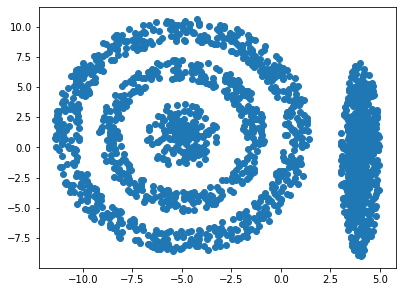

In [4]:
dsc:{[n;r;s](r+n?s-r)*/:(cos;sin)@\:4*n?acos 0}
d1 :flip(-5 1)+(1 1.5)*dsc[1000; 0;1.8],'dsc[2000;3.1;4.2],'dsc[4000;5.2;6.5]
d1,:flip(4 -1)+(1 8)*dsc[4000; 0;1.]
d1@:neg[2000&count d1]?count d1
plt[`:scatter][;]. flip d1;
plt[`:show][];

22886 618000


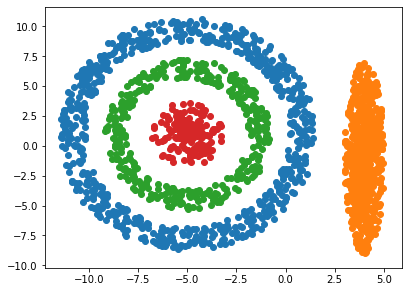

In [5]:
\ts r1:.ml.clust.cure[d1;4;50;()]
{plt[`:scatter][;]. flip x}each exec pts by clt from r1;
plt[`:show][];

### Adding compression

In cases where the dataset provided contains outliers or has clusters of varying sizes and shapes, adding compression can be used to improved the clusters produced.

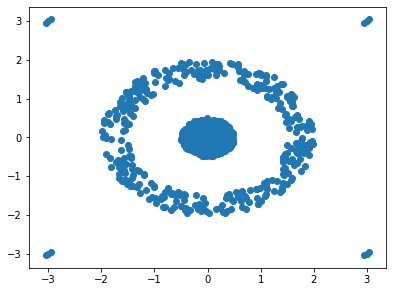

In [6]:
d2:read[fcps`:SAMPLE_TARGET]`
plt[`:scatter][;]. flip d2;
plt[`:show][];

550 286768


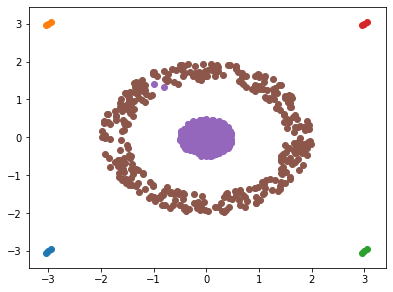

In [7]:
\ts r2:.ml.clust.cure[d2;6;5;()]
{plt[`:scatter][;]. flip x}each exec pts by clt from r2;
plt[`:show][];

Points in the two most central clusters have been assigned to clusters incorrectly. This can be improved by adding a small compression of `0.1`.

559 287632


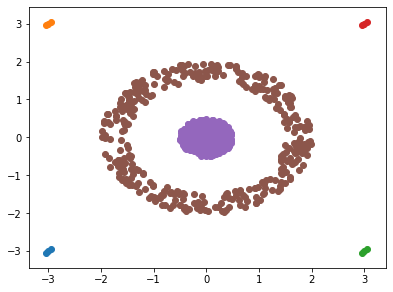

In [8]:
\ts r2c:.ml.clust.cure[d2;6;5;`c`b!(.1;0b)]
{plt[`:scatter][;]. flip x}each exec pts by clt from r2c;
plt[`:show][];

---

<a id='DBSCAN'></a>
## DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

The DBSCAN algorithm groups points together that are closely packed in areas of high-density. Any points in low-density regions are seen as outliers.

Unlike other clustering algorithms which require the user to input the desired number of clusters, DBSCAN will decide how many clusters are in the dataset based the minimum number of points required per cluster and the epsilon radius, both given by the user.

### Inputs

DBSCAN is called using the function `.ml.clust.dbscan` which takes the followning arguments:
* `d` is data points in matrix form
* `df` is the distance function as a symbol: `` `e2dist`edist`mdist``
* `p` is minimum number of points required in a given neighbourhood for it to be classified as a cluster
* `e` is the epsilon radius, the distance from each point within which points are defined as being in the same cluster

### Example

Below shows how DBSCAN can be used to cluster data in odd shapes, such a crescent moons. Distance based models would struggle to correctly classify points in the below datasets as clusters are in close proximity and so points could easily be included in the wrong cluster. However, density based DBSCAN is able to distinguish between the clusters given that points in each are densely packed.

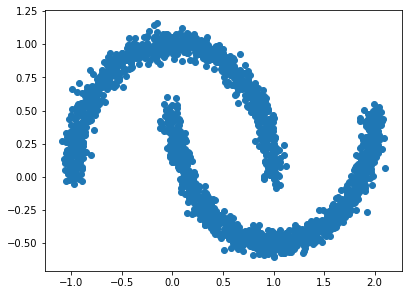

In [9]:
d3:skds[`:make_moons][`n_samples pykw 2000;`noise pykw 0.05]`
plt[`:scatter][;]. flip d3@:0;
plt[`:show][];

384 21181936


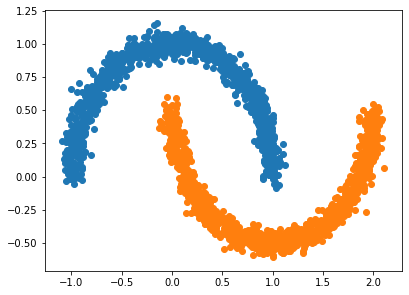

In [10]:
\ts r3:.ml.clust.dbscan[d3;`e2dist;6;.05]
{plt[`:scatter][;]. flip x}each exec pts by clt from r3;
plt[`:show][];

---

<a id='HC'></a>
## Hierarchical

As the name suggests, hierarchical clustering algorithms create a hierarchy of clusters. The implementation described here follows an agglomerative approach, where each data point is initially treated as its own cluster. 

There are 5 possible linkages in hierarchical clustering: single, complete, average, centroid and ward. Euclidean or manhattan distances can be used for with each linkage, except for ward which only works with euclidean squared distances. Additionally, a k-d tree has been used for the single and centroid implementations.

At each step, the two closest clusters (defined by the linkage) are merged until only one cluster remains, which contains all of the data points. Results are usually represented by a dendrogram, used to suggest the “appropriate” number of clusters in the data. 

### Inputs

To create a dendrogram, the function `.ml.clust.dgram` is called which takes the followning arguments:
* `d` is data points in matrix form
* `df` is the distance function as a symbol: `` `e2dist`edist`mdist``
* `lf` is the linkage function as a symbol: `` `single`complete`average`centroid`ward ``

Given that dendrograms do not actually return lists of clustered data points, the function `ml.clust.hc` has been provided to allow users to define the number of clusters to return using the following parameters:
* `d` is data points in matrix form
* `k` is the number of clusters
* `df` is the distance function as a symbol: `` `e2dist`edist`mdist``
* `lf` is the linkage function as a symbol: `` `single`complete`average`centroid`ward ``

### Examples

For simplicity we only showcase some of the hierarchical linkages below. The function `plot` has been used to plot the clustered data and dendrograms for example.

In the first case shown below we use ward linkage, which can only be used in conjunction with squared euclidean distances.

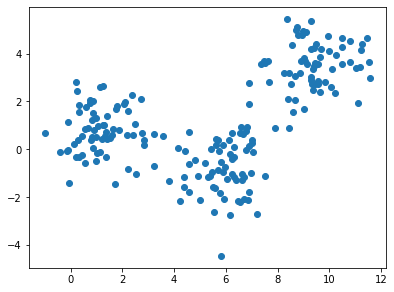

In [11]:
d4:skds[`:make_blobs][`n_samples pykw 200;`random_state pykw 449]`
plt[`:scatter][;]. flip d4@:0;
plt[`:show][];

76 53968


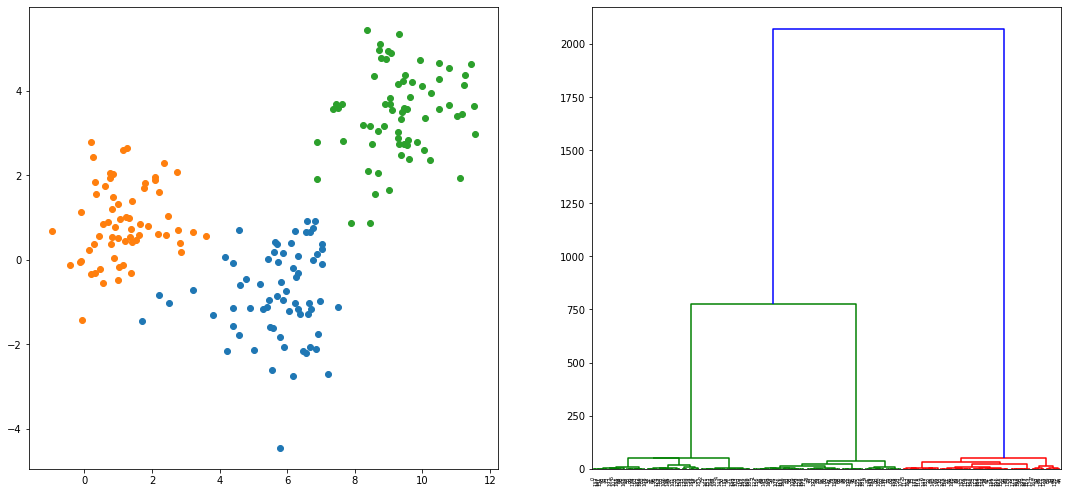

In [15]:
\ts r4:.ml.clust.hc[d4;3;`e2dist;`ward;0b]
plot[d4;3;`e2dist;`ward;()] /can pass in `cluster`dgram or () to plot both

Below we use single linkage to cluster dataset containing clusters of concentric circles defined earlier in the notebook. It is clear that single linkage performs well with circles, similarly to CURE.

In [16]:
\ts r5:.ml.clust.hc[d1;4;`mdist;`single;0b]
plot[d1;4;`mdist;`single;()]

6189 597520


[0;31mclust.ccure[0m: [0;31mclust.ccure[0m

---

<a id='KMeans'></a>
## K-Means

K-means clustering begins by selecting k data points as cluster centres and assigning data to the cluster with the nearest centre. The algorithm follows an iterative refinement process which will run n times, updating the cluster centers and assigned points during each iteration.

### Inputs

K-means is called using the function `.ml.clust.kmeans` which takes the followning arguments:
* `d` is data points in matrix form
* `k` is the number of clusters
* `n` is the number of iterations
* `i` is a boolean flag indicating the initialisaton type: both select k points from the dataset as cluster centres, `1b` initialises the [k-means++](https://en.wikipedia.org/wiki/K-means%2B%2B) algorithm or `0b` selects k random points
* `df` is the distance function as a symbol: `` `e2dist`edist`mdist``

### Example

Below shows a dataset with no structure. K-means is able to cluster this dataset into even clusters compared to other algorithms.

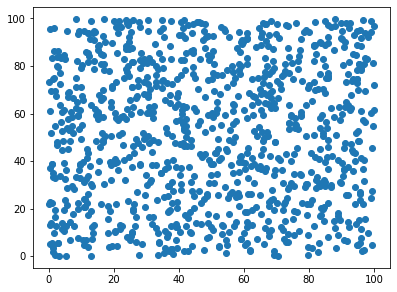

In [19]:
d6:1000 2#2000?100.
plt[`:scatter][;]. flip d6;
plt[`:show][];

50 154768


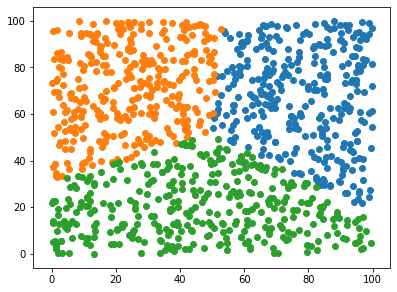

In [20]:
\ts r6:.ml.clust.kmeans[d6;3;100;1b;`e2dist]
{plt[`:scatter][;]. flip x}each exec pts by clt from r6;
plt[`:show][];

---

<a id='Comp'></a>
# Comparing algorithms

In this section we show how using the different clustering algorithms on the same datasets can produce vastly different results.

In [25]:
show df:key .ml.clust.i.dd    / distance metrics
show lf:key .ml.clust.i.ld    / linkage metrics

`e2dist`edist`mdist`cshev`nege2dist
`single`complete`average`centroid`ward


### Example 1

This first example aims to cluster mall customer data from [Kaggle](https://www.kaggle.com/shwetabh123/mall-customers/downloads/mall-customers.zip/1). The data contains information on customers gender, age, annual income and spending score.

In [28]:
show 5#d1:("SSFFF";(),",")0:`:../data/Mall_Customers.csv

CustomerID Genre  Age AnnualIncome SpendingScore
------------------------------------------------
0001       Male   19  15           39           
0002       Male   21  15           81           
0003       Female 20  16           6            
0004       Female 23  16           77           
0005       Female 31  17           40           


We are only interested in annual income and spending score. Plotting these two features, as shown below, produces roughly 5-7 clusters.

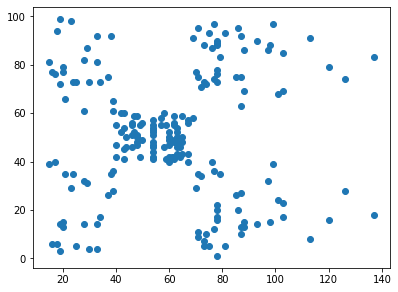

In [30]:
d1:distinct flip d1`AnnualIncome`SpendingScore
plt[`:scatter]. flip d1;
plt[`:show][];

We can now cluster the data using each of the above clustering algorithms.

First, CURE is used and manages to cluster the data into 4 clusters at best when manhattan distances and a compression of 1 are used.

In [30]:
plotcluster[`cure;d2;(4;5),/:enlist each{![`df`c`b;x]}each(cross/)(-1_df;1;01b)]

[0;31mclust.ccure[0m: [0;31mclust.ccure[0m

DBSCAN struggles to cluster anything other than the central clump of datapoints, regardless of the input values used.

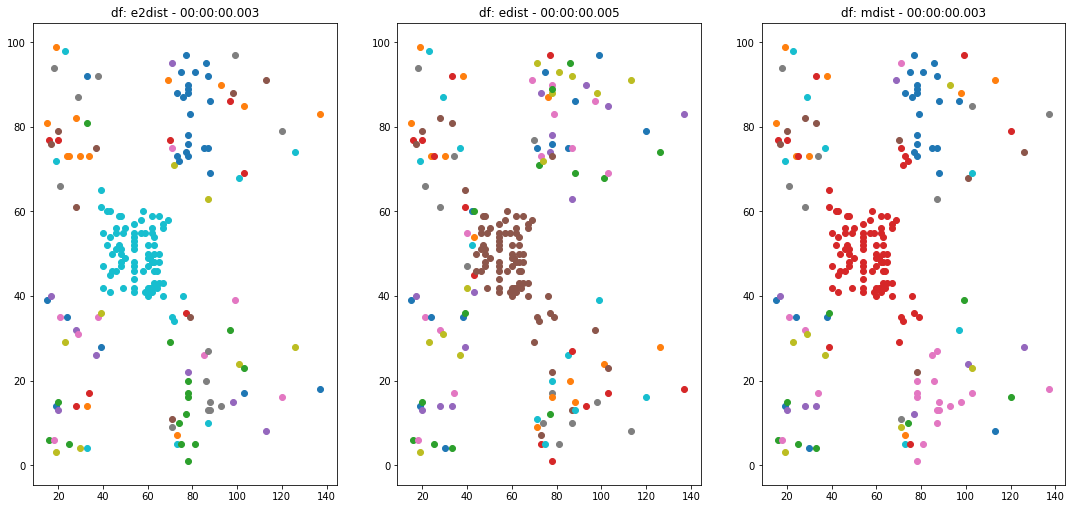

In [11]:
plotcluster[`dbscan;d2;(-1_df),'(10 100;40 15;20 19)]

Hierarchical...

In [30]:
plotcluster[`hc;d2;((cross/)(4;-1_df;`single`centroid;01b)),(cross/)(4;-1_df;`average`complete;0b)]

[0;31mclust.ccure[0m: [0;31mclust.ccure[0m

Ward perfectly clusters that data into 5 clusters.

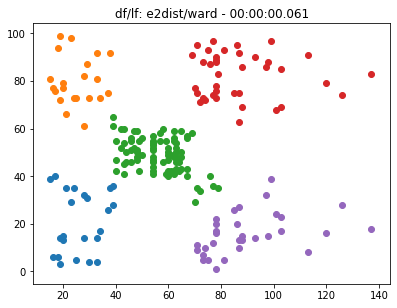

In [32]:
plotcluster[`ward;d2;(5;`e2dist;`ward;0b)]

Similarly, k-means performs well with both Euclidean and Manhattan distances.

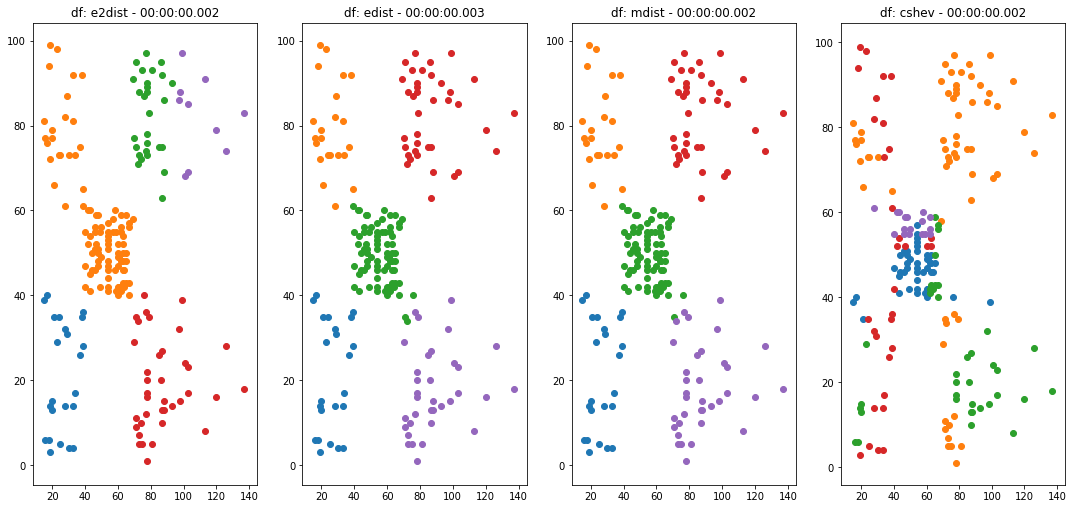

In [14]:
plotcluster[`kmeans;d2;(cross/)(5;20;1b;df)]

### Example 2

It is also interesting to see how each of the clustering algorithms perform in 3D situations. The dataset used in this example consists of two rings with a common centre, a shape which is normally very hard to cluster.

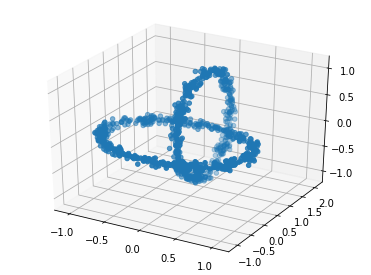

In [33]:
d4:read[fcps`:SAMPLE_CHAINLINK]`
fig:plt[`:figure][];
ax:fig[`:add_subplot][111;`projection pykw"3d"];
ax[`:scatter][;;]. flip d4;
plt[`:show][];

CURE handles these types of datasets particularly well and is able to identify the two rings.

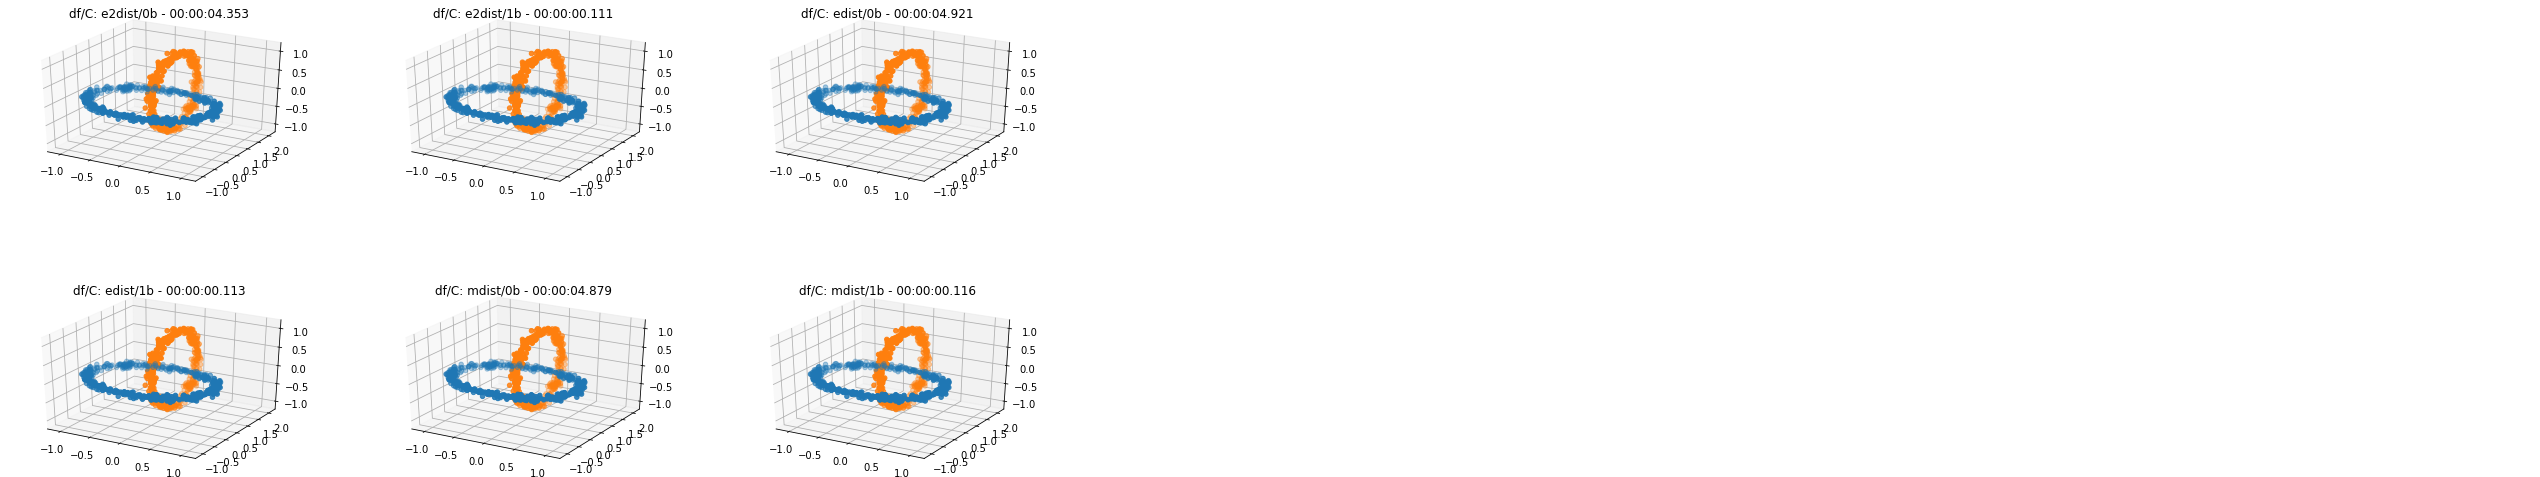

In [22]:
plotcluster[`cure;d4;(2;30),/:enlist each{![`df`b;x]}each(cross/)(-1_df;01b)]

DBSCAN only performs well when Euclidean distances are used.

In [33]:
plotcluster[`dbscan;d4;(cross/)(-1_df;100;.6)]

[0;31mcall: num must be 1 <= num <= 3, not 4[0m: [0;31mcall: num must be 1 <= num <= 3, not 4[0m

Hierarchical...

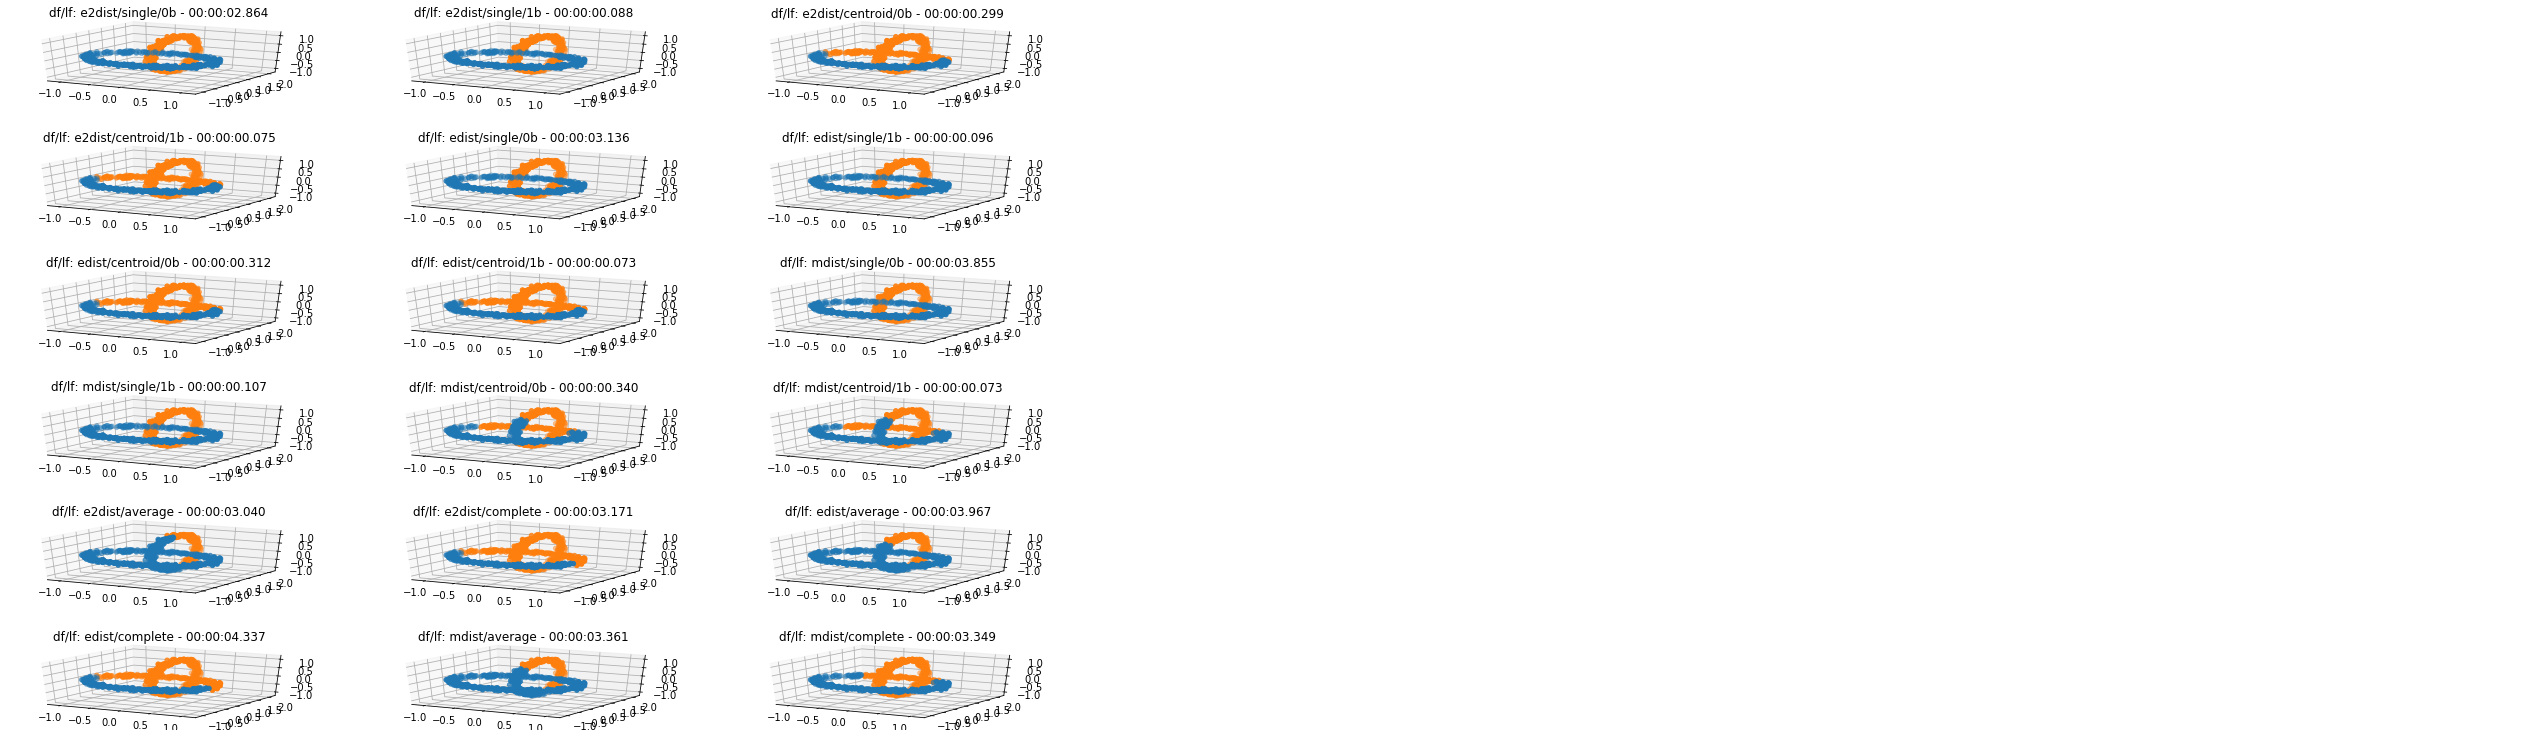

In [24]:
plotcluster[`hc;d4;((cross/)(2;-1_df;`single`centroid;01b)),(cross/)(2;-1_df;`average`complete;(::))]

Ward performs well with Squared Euclidean distances.

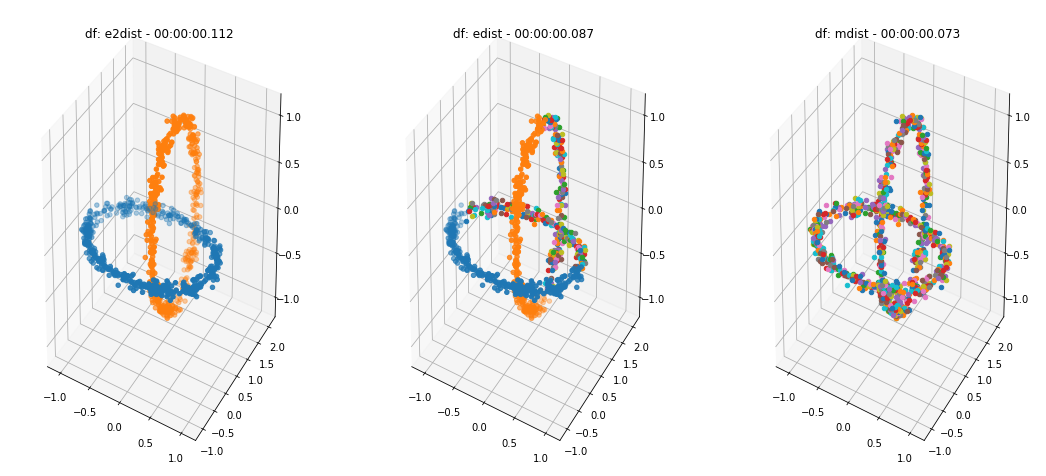

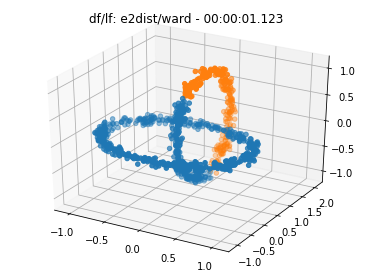

In [34]:
plotcluster[`ward;d4;(2;`e2dist;`ward;0b)]

K-Means ...

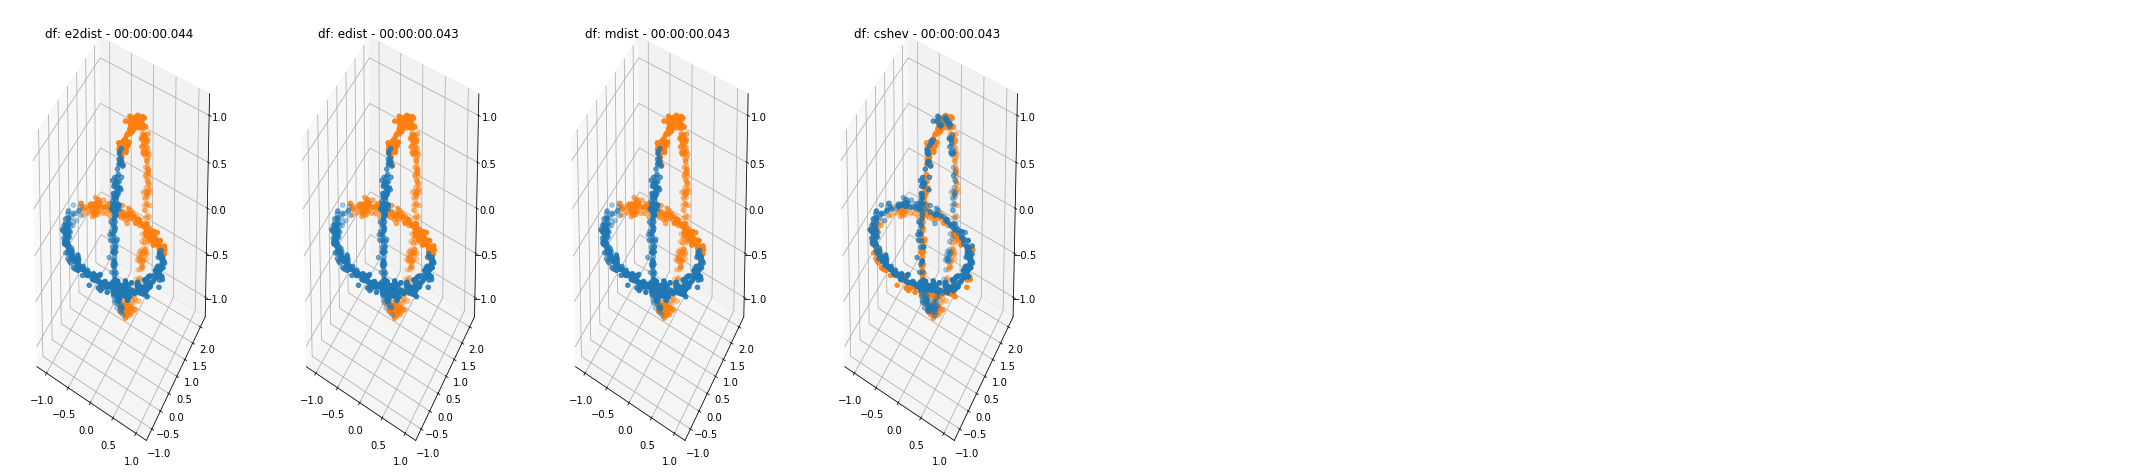

In [26]:
plotcluster[`kmeans;d4;(cross/)(2;100;1b;df)]

---